In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns

In [69]:
import matplotlib.ticker as ticker
from scipy.ndimage import median_filter
from scipy.interpolate import griddata

In [3]:
connectivity_min, connectivity_max = 0,130
delay_min, delay_max = 0,3
# random_input_span = (1.2,2.8)
random_input_span = (9.5,13.5)
total_time = 100
alpha = 20
alpha_folder = 'alpha_' + str(alpha)

current_models = ['IF','Rotational','Non_repulsive_rotational']
neuron_model = current_models[2]

model_folder_name = neuron_model+'_ensembles'
version = '_v1.0'
# version = '_cluster_computed'

# Capture related ensembles

In [4]:
def list_folders_in_path(path):
    return [ name for name in os.listdir( path ) if os.path.isdir( os.path.join(path, name) ) ]

In [5]:
num_neurons = 10000
target_networks_name = 'N{}_T{}_I{}_{}'.format(num_neurons,total_time,random_input_span[0],random_input_span[1]) + version
target_path = os.path.join(model_folder_name,target_networks_name)
all_g_folders = list_folders_in_path(target_path)
desired_g_folders = all_g_folders

# delay_folder_name = 'd_{}'.format(delay)

In [6]:
sigma_glossary_dict = {}
amin_saman_param_glossary_dict = {}
field_period_glossary_dict = {}
field_max_intensity_mod_glossary_dict = {}

In [7]:
for g_folder in desired_g_folders:
    available_d_folders = list_folders_in_path(os.path.join(target_path,g_folder))

    g = float( g_folder.split('_')[1] ) #folder names are g_# d_#
    
    if g > connectivity_max or g < connectivity_min: continue #check if this connectivity is requested
    
    sigma_glossary_dict[g] = {}
    amin_saman_param_glossary_dict[g] = {}
    field_period_glossary_dict[g] = {}
    field_max_intensity_mod_glossary_dict[g] = {}
    
    for d_folder in available_d_folders:
        delay = float( d_folder.split('_')[1] ) #folder names are d_#
        if delay > delay_max or delay < delay_min: continue #check if this connectivity is requested
        g_d_alpha_path = os.path.join(target_path, g_folder, d_folder, alpha_folder)

        try:
            g_ensembles_list = list_folders_in_path(g_d_alpha_path)
            
            sigma_glossary_dict[g].update( {delay:[]} )
            amin_saman_param_glossary_dict[g].update( {delay:[]} )
            field_period_glossary_dict[g].update( {delay:[]} )
            field_max_intensity_mod_glossary_dict[g].update( {delay:[]} )
        except: #if the given connectivity and delay has not been measured even once
            continue

        for ensemble_num in g_ensembles_list:
            ensemble_path = os.path.join(g_d_alpha_path, ensemble_num)
            with open( os.path.join(ensemble_path,'sigma.txt') ) as file:
                sigma = float( file.readline() )
                sigma_glossary_dict[g][delay].append( sigma )

            with open( os.path.join(ensemble_path,'field_properties.txt') ) as file:
                info_line = file.readline()
                field_period = float( info_line.split(',')[0] )
                max_intensity_mod = float( info_line.split(',')[1] )
                field_period_glossary_dict[g][delay].append( field_period )
                field_max_intensity_mod_glossary_dict[g][delay].append( max_intensity_mod )

            if neuron_model in ['Rotational','Non_repulsive_rotational']: #if not does not exist
                with open( os.path.join(ensemble_path,'amin_saman_param.txt') ) as file:
                    amin_saman_param = float( file.readline() )        
                    amin_saman_param_glossary_dict[g][delay].append( amin_saman_param )        


        sigma_glossary_dict[g][delay] = np.mean(sigma_glossary_dict[g][delay])
        field_period_glossary_dict[g][delay] = np.mean(np.abs( field_period_glossary_dict[g][delay] ) )
        field_max_intensity_mod_glossary_dict[g][delay] = np.mean(field_max_intensity_mod_glossary_dict[g][delay])
        if neuron_model in ['Rotational','Non_repulsive_rotational']:amin_saman_param_glossary_dict[g][delay] = np.mean(amin_saman_param_glossary_dict[g][delay])


In [67]:
def dict_to_dataframe(input_dict):
    table = pd.DataFrame.from_dict(input_dict)
    table.index.name = 'delay'
    table.columns.name = 'connectivity'
    table = table.sort_index(axis=1)
    return table

def create_contour_phase_space(dataframe, title):
    delay_list = dataframe.index.to_list()
    g_list = dataframe.columns.to_list()
    
    fig = plt.figure()
    ax = fig.add_subplot()

    yticklabels = ['{:.2f}'.format(x) for x in delay_list]
    xticklabels = ['{:.1f}'.format(x) for x in g_list]
    
    extent = [min(g_list),max(g_list),min(delay_list),max(delay_list)]
    
    dataframe_filtered = median_filter(dataframe, size=1)
    contours = ax.contourf(dataframe_filtered, cmap = 'inferno', locator = ticker.FixedLocator(dataframe.index.to_list()), extent = extent)

    C = ax.contour(dataframe_filtered, colors='black', linewidth=.5, locator = ticker.FixedLocator(dataframe.index.to_list()), extent = extent)
    ax.clabel(C, inline=1, fontsize=10)
    
    ax.yaxis.set_major_formatter(ticker.FixedFormatter(yticklabels))
#     ax.xaxis.set_major_formatter(ticker.IndexFormatter(xticklabels))
    ax.yaxis.set_major_locator(ticker.FixedLocator(delay_list))
#     ax.yaxis.set_major_locator(ax.yaxis.get)
        
    ax.set_title('{} phase space (with median filter)'.format(title))
    ax.set_xlabel('Connectivity')
    ax.set_ylabel('Delay (s)')
    plt.close()
    return fig

In [63]:
# params = {"ytick.color" : "w",
#           "xtick.color" : "w",
#           "axes.labelcolor" : "w",
#           "axes.edgecolor" : "w"}
# plt.rcParams.update(params)

In [56]:
plt.contour?

In [10]:
sns.set_theme(context='paper', font= 'Serif', style = 'ticks')

# Sigma dataframe

In [11]:
sigma_table = dict_to_dataframe(sigma_glossary_dict)
sigma_table.head()

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.02,0.212660,0.197392,0.165363,0.147229,0.138979,0.131175,0.127657,0.122228,0.118067,0.114509,...,0.138714,0.140539,0.141112,0.140291,0.140650,0.139421,0.140257,0.138529,0.140102,0.141204
0.04,0.213549,0.205290,0.185588,0.171899,0.164607,0.161022,0.159897,0.158716,0.156290,0.152779,...,0.188878,0.188744,0.189512,0.187897,0.187941,0.187484,0.186338,0.185508,0.187760,0.186098
0.06,0.215418,0.208821,0.203132,0.198334,0.191694,0.189712,0.187496,0.186100,0.184833,0.183945,...,0.225937,0.225242,0.225883,0.225058,0.224297,0.225237,0.224589,0.225222,0.223690,0.221525
0.08,0.217391,0.211942,0.206235,0.203972,0.202809,0.204375,0.204713,0.204387,0.204929,0.206782,...,0.255586,0.254663,0.254745,0.253807,0.254352,0.253085,0.253348,0.252334,0.252319,0.251606


C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/2442720307.py:7: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))


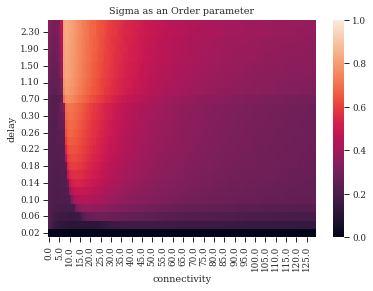

In [24]:
yticklabels = ['{:.2f}'.format(x) for x in sigma_table.index.to_list()]
ax_sigma = sns.heatmap(sigma_table, annot=False, vmax = 1)

ax_sigma.set_title('Sigma as an Order parameter')
ax_sigma.invert_yaxis()

ax_sigma.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))

In [70]:
griddata(sigma_table)

TypeError: griddata() missing 2 required positional arguments: 'values' and 'xi'

In [25]:
fig = ax_sigma.get_figure()
fig.savefig(os.path.join(target_path, 'sigma_phase_space.png'), dpi = 1000)

C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/793541782.py:23: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(dataframe_filtered, colors='black', linewidth=.5, locator = ticker.FixedLocator(dataframe.index.to_list()), extent = extent)
C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/793541782.py:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.yaxis.set_major_formatter(ticker.FixedFormatter(yticklabels))


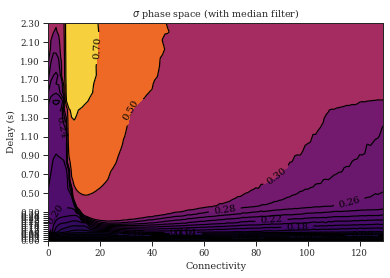

In [68]:
c_fig = create_contour_phase_space(sigma_table, r'$\sigma$')
c_fig.savefig(os.path.join(target_path, 'sigma_phase_space_contour.png'), dpi = 1000)
c_fig

# Amin Saman Parameter

C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(dataframe_filtered, colors='black', linewidth=.5)
C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:22: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))
C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:23: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.xaxis.set_major_formatter(ticker.IndexFormatter(xticklabels))


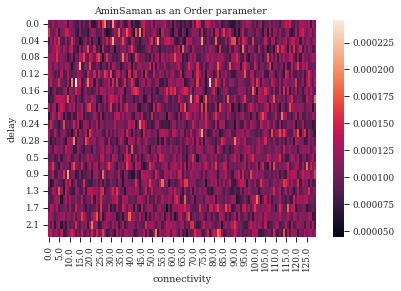

In [15]:
if neuron_model in ['Rotational','Non_repulsive_rotational']:
    amin_saman_param_table = dict_to_dataframe(amin_saman_param_glossary_dict)
    ax_field_period = sns.heatmap(amin_saman_param_table)
    ax_field_period.set_title('AminSaman as an Order parameter ')
    fig = ax_field_period.get_figure()
    fig.savefig(os.path.join(target_path, 'amin_saman_phase_space.png'))
    
    create_contour_phase_space(amin_saman_param_table, 'AminSaman').savefig(os.path.join(target_path, 'amin_saman_phase_space_contour.png'), dpi = 1000)

# Field period dataframe

In [16]:
field_period_table = dict_to_dataframe(field_period_glossary_dict)
field_period_table.head()

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0
delay,,,,,,,,,,,,,,,,,,,,,
0.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
0.02,0.465116,0.529101,0.588235,0.641026,0.699301,0.757576,0.800000,0.561798,0.578035,0.671141,...,0.393701,0.398406,0.403226,0.401606,0.404858,0.404858,0.406504,0.404858,0.409836,0.413223
0.04,0.465116,0.529101,0.588235,0.645161,0.699301,0.751880,0.806452,0.543478,0.584795,0.632911,...,0.555556,0.552486,0.561798,0.555556,0.558659,0.558659,0.561798,0.561798,0.568182,0.568182
0.06,0.465116,0.526316,0.588235,0.645161,0.699301,0.751880,0.800000,0.847458,0.892857,0.952381,...,0.694444,0.704225,0.704225,0.709220,0.714286,0.719424,0.714286,0.719424,0.719424,0.719424
0.08,0.465116,0.526316,0.584795,0.649351,0.699301,0.751880,0.806452,0.847458,0.892857,0.934579,...,0.840336,0.840336,0.847458,0.847458,0.854701,0.854701,0.862069,0.862069,0.869565,0.869565


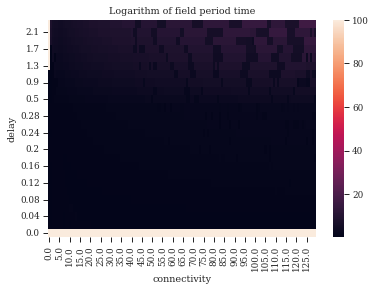

In [17]:
# ax_field_period = sns.heatmap(np.log(field_period_table.abs()), annot=False, vmax = 2, vmin = -2)
ax_field_period = sns.heatmap(field_period_table.abs(), annot=False)
ax_field_period.set_title('Logarithm of field period time')
ax_field_period.invert_yaxis()

In [18]:
fig = ax_field_period.get_figure()
fig.savefig(os.path.join(target_path, 'field_period_phase_space.png'))

C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(dataframe_filtered, colors='black', linewidth=.5)
C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:22: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))
C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:23: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.xaxis.set_major_formatter(ticker.IndexFormatter(xticklabels))


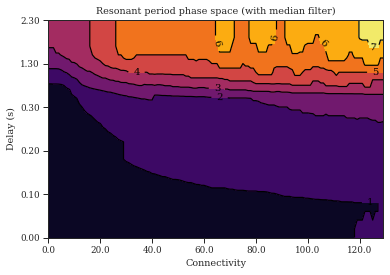

In [19]:
c_fig = create_contour_phase_space(field_period_table.abs(), 'Resonant period')
c_fig.savefig(os.path.join(target_path, 'field_period_phase_space_contour.png'), dpi = 1000)
c_fig

In [20]:
max_intensity_table = dict_to_dataframe(field_max_intensity_mod_glossary_dict)
max_intensity_table.head()

connectivity,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,120.0,121.0,122.0,123.0,124.0,125.0,126.0,127.0,128.0,129.0
delay,,,,,,,,,,,,,,,,,,,,,
0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0.02,242.497167,219.128893,188.546161,142.184789,130.644606,93.247766,94.577319,73.097619,67.568618,62.678451,...,344.151755,323.386595,345.686553,343.767641,403.746103,378.586474,422.869126,407.694533,407.024224,454.972965
0.04,252.969411,217.517618,201.050014,159.681826,130.933224,126.589511,99.862566,98.450915,94.822266,87.650329,...,533.120720,458.671467,425.860985,436.423435,496.229872,465.992749,353.283186,430.833736,485.851522,413.902619
0.06,237.283973,219.135549,205.892174,200.112846,170.015096,151.126344,154.226503,131.482472,121.703421,107.485395,...,461.669986,541.873846,395.725034,576.940855,479.580235,527.139512,527.563976,488.714946,494.005599,522.737653
0.08,246.841596,210.729123,191.638379,203.320600,170.438407,174.128709,165.833313,147.579368,141.088904,122.609035,...,616.830037,427.631837,604.841056,643.522503,564.208074,619.961486,527.383154,512.561402,459.597195,423.241743


C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:15: UserWarning: The following kwargs were not used by contour: 'linewidth'
  C = ax.contour(dataframe_filtered, colors='black', linewidth=.5)
C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:22: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.yaxis.set_major_formatter(ticker.IndexFormatter(yticklabels))
C:\Users\mohsen\AppData\Local\Temp/ipykernel_7852/1626521888.py:23: MatplotlibDeprecationWarning: 
The IndexFormatter class was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax.xaxis.set_major_formatter(ticker.IndexFormatter(xticklabels))


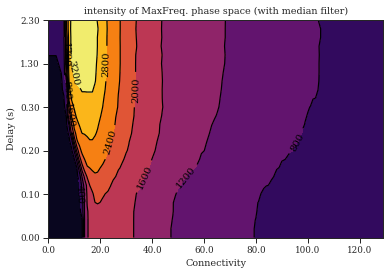

In [21]:
c_fig = create_contour_phase_space(max_intensity_table, 'intensity of MaxFreq.')
c_fig.savefig(os.path.join(target_path, 'max_intensity_phase_space_contour.png'), dpi = 1000)
c_fig

In [22]:
# %matplotlib notebook
# from mpl_toolkits.mplot3d import Axes3D

# d_arr = max_intensity_table.index
# g_arr = max_intensity_table.columns
# bars_pos = np.array([np.tile(g_arr, len(d_arr)), np.repeat(d_arr, len(g_arr)), [0]*(len(d_arr)*len(g_arr))])

# dd_arr = d_arr[1] - d_arr[0]
# dg_arr = g_arr[1] - g_arr[0]

# dmax_intensity = max_intensity_table.to_numpy().flatten()

# cmap = plt.cm.get_cmap('magma') # Get desired colormap - you can change this!
# period_arr = field_period_table.to_numpy().flatten()
# max_height = np.max(period_arr)   # get range of colorbars so we can normalize
# min_height = np.min(period_arr)
# # scale each z to [0,1], and get their rgb values
# rgba = [cmap( np.log( k ) ) for k in period_arr] 


# fig = plt.figure()          #create a canvas, tell matplotlib it's 3d
# # ax = fig.add_subplot(111, projection='3d')
# # ax.bar3d(bars_pos[0], bars_pos[1], bars_pos[2], dg_arr, dd_arr, dmax_intensity, color=rgba)